### Import Modules

In [5]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings('ignore')
%matplotlib nbagg

# Class

In [6]:
class idm_singlelane():
    
    def parameters(self, v0, T, a, b, delta, lc, s0, s1, lr):
        self.v0 = v0
        self.T = T
        self.a = a
        self.b = b
        self.delta = delta
        self.lc = lc
        self.s0 = s0
        self.s1 = s1
        self.lr = lr
    
    
    def initial_conditions(self, n_cars, x_init, v_init, is_bottleneck=False, bottleneck_pos=None):
        self.n_cars = n_cars
        self.x_init = x_init
        self.v_init = v_init
        self.is_bottleneck = is_bottleneck
        self.bottleneck_pos = bottleneck_pos
    
    
    def simulate(self, dt, t_final):
        ## order cars by decreasing position (farthest first)
        ind = np.argsort(self.x_init)[::-1]
        x0 = self.x_init[ind]
        v0 = self.v_init[ind]
        
        ## solve differential equations
        y0 = np.append(x0, v0)
        t = np.arange(0, t_final+dt, dt)
        sol = odeint(self.idm, y0, t)
        
        # keep position values between 0 and lr
        sol[:,:len(x0)] = np.mod(sol[:,:len(x0)], self.lr)
        
        return(sol)
        
        
    def idm(self, y, t):
        dydt = np.zeros(len(y))
        n = int(len(y)/2)
        
        for i in range(n):
            if i==0:
                ss = 1/(y[n-1] - y[0] - self.lc + self.lr)**2  # inverse square of bumper-to-bumper gap
                va = y[2*n-1]  # velocity of car ahead
            else:
                ss = 1/(y[i-1] - y[i] - self.lc)**2
                va = y[n+i-1]
            
            vc = y[n+i]  # velocity of current car
            
            dydt[i] = vc
            dydt[n+i] = self.a * (1 - (vc/self.v0)**self.delta 
                                  - ss*(self.s0
                                        + self.s1*np.sqrt(vc/self.v0)
                                        + self.T*vc 
                                        + 1/(2*np.sqrt(self.a*self.b))*vc*(va-vc))**2)
        
        return(dydt)

# Main

### Initialization

In [7]:
## initialize model
model = idm_singlelane()

### Parameters

In [8]:
## define parameters of interest
v0 = 10/3     # desired velocity (m/s)
T = 1.6       # safe time headway (s)
a = 0.73      # maximum acceleration (m/s2)
b = 5/3       # comfortable decceleration (m/s2)
delta = 4     # acceleration exponent
lc = 4        # length of car (m)
s0 = 2        # linear jam distance (m)
s1 = 3        # non-linear jam distance (m)
lr = 1000     # length of road (m)

## fit parameters into model
model.parameters(v0=v0, T=T, a=a, b=b, delta=delta, lc=lc, s0=s0, s1=s1, lr=lr)

## Initial Conditions

### Free Traffic

In [9]:
## specify initial conditions
n_cars = 10   # number of cars
x_init = t = np.arange(0, lr, lr/n_cars)  # initial position of cars
v_init = 1*np.ones(n_cars)  # initial velocity of cars

## fit initial conditions into model
model.initial_conditions(n_cars=n_cars, x_init=x_init, v_init=v_init)

### Downstream Traffic

In [10]:
## specify initial conditions
n_cars = 35
x_init = np.cumsum(6+np.arange(0,7,0.2)**2)
v_init = 1*np.ones(n_cars)  # initial velocity of cars

## fit initial conditions into model
model.initial_conditions(n_cars=n_cars, x_init=x_init, v_init=v_init)

### Upstream Traffic

In [40]:
## specify initial conditions
n_cars = 35
x_init = 1000-np.cumsum(6+np.arange(0,7,0.2)**2)
v_init = 1*np.ones(n_cars)  # initial velocity of cars

## fit initial conditions into model
model.initial_conditions(n_cars=n_cars, x_init=x_init, v_init=v_init)

### Green Light

In [6]:
## specify initial conditions
n_cars = 35
x_init = np.arange(0,217,6.2)
v_init = np.zeros(n_cars)  # initial velocity of cars

## fit initial conditions into model
model.initial_conditions(n_cars=n_cars, x_init=x_init, v_init=v_init)

## Simulation

In [11]:
dt = 0.1      # update time (s)
t_final = 1000  # simulation time (s)

## begin simulation
t1 = time.time()
sol = model.simulate(dt, t_final)
t2 = time.time()

print("Simulation Time:", t2-t1)

## record results

Simulation Time: 1.3190534114837646


## Visualization

<IPython.core.display.Javascript object>


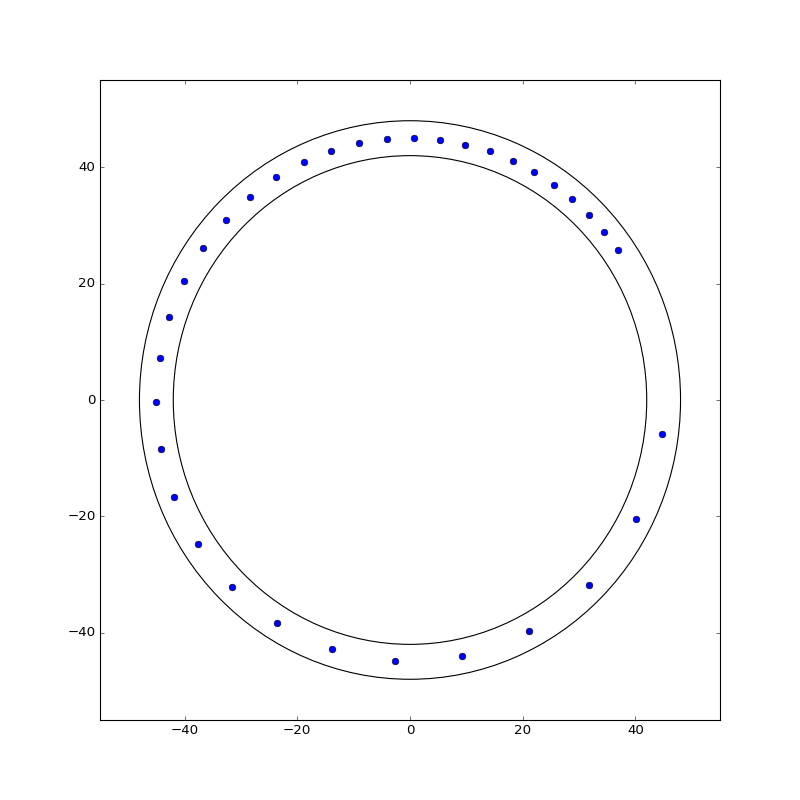

KeyboardInterrupt: 

In [12]:
import time

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# initial x and y data
pos_rad = np.divide(sol[:,:sol.shape[1]/2], lr) * 2*np.pi
x = 45 * np.cos(pos_rad)
y = 45 * np.sin(pos_rad)

li, = ax.plot(x[0,:], y[0,:], 'o')

# draw circular road
circle1 = plt.Circle((0, 0), 42, color='k', fill=False)
circle2 = plt.Circle((0, 0), 48, color='k', fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)

# draw and show it
fig.canvas.draw()
plt.xlim([-55,55])
plt.ylim([-55,55])
plt.show(block=False)

# loop to update the data
for i in range(1,x.shape[0],10):
    # set the new data
    li.set_xdata(x[i,:])
    li.set_ydata(y[i,:])

    fig.canvas.draw()

<IPython.core.display.Javascript object>


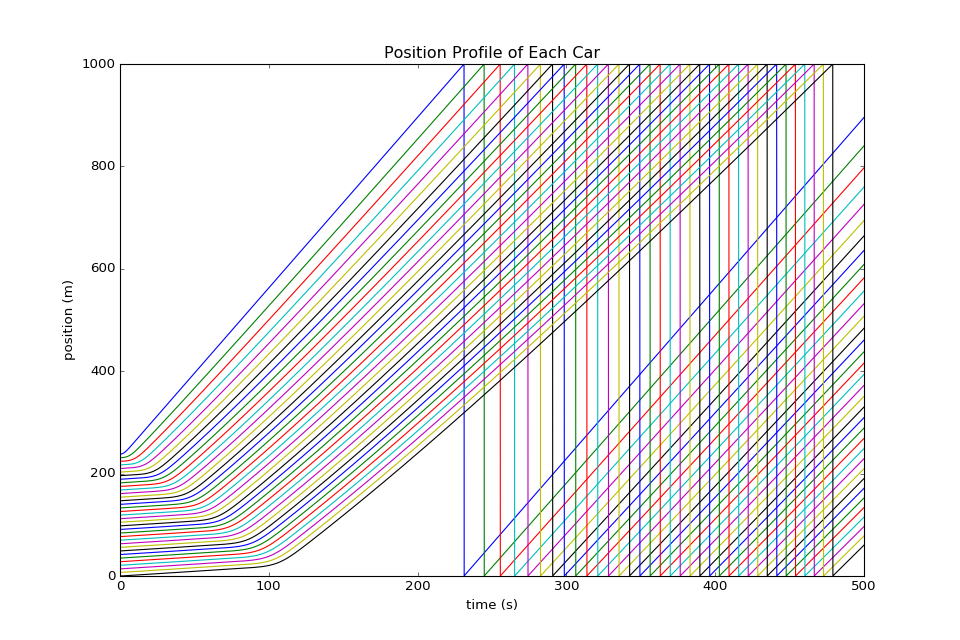

In [70]:
t = np.arange(0, t_final+dt, dt)

plt.figure(figsize=(12,8))

for i in range(int(sol.shape[1]/2)):
    plt.plot(t, sol[:,i])

plt.title("Position Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.show()

<IPython.core.display.Javascript object>


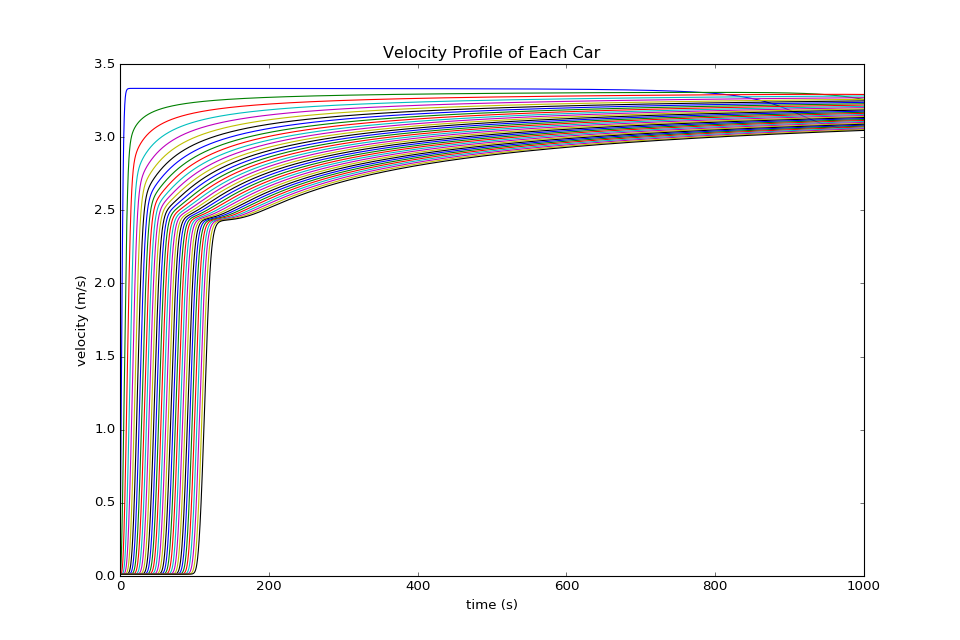

In [9]:
t = np.arange(0, t_final+dt, dt)

plt.figure(figsize=(12,8))

for i in range(int(sol.shape[1]/2), sol.shape[1]):
    plt.plot(t, sol[:,i])

plt.title("Velocity Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.show()